In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import itertools
import operator

In [2]:
## This function for plotting confusion matrix is adapted from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """


    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
def genre(genre,list):
    if genre in list:
        return 1
    else:
        return 0
genre_vec = np.vectorize(genre)

def find_all_genres(df):
    dict = {}
    for genre in df['omdb_genres']:
        for each in genre:
            if each not in dict:
                dict.update({each:1})
            else:
                dict[each] += 1
    return dict

omdb = pd.read_json('omdb-data.json.gz', orient='record', lines=True).dropna(how = "any")

In [4]:
omdb = omdb[['omdb_genres','omdb_plot']]
omdb['omdb_plot'] = omdb['omdb_plot'].astype('str')
omdb.head()
# omdb['omdb_plot'][0]

,omdb_genres,omdb_plot
0,"[Drama, History, War]","In this sprawling, star-laden film, we see the..."
1,"[Action, Adventure, Thriller]",A cryptic message from the past sends James Bo...
2,"[Comedy, Horror]","The makers of this parody of ""Night of the Liv..."
3,"[Adventure, Comedy, Drama]",Jack Crabb is 121 years old as the film begins...
4,"[Crime, Drama, Thriller]","When Perry and his girlfriend, Gail, cross pat..."


## Distribution of length of plot summary

Max:  7104
Min:  3


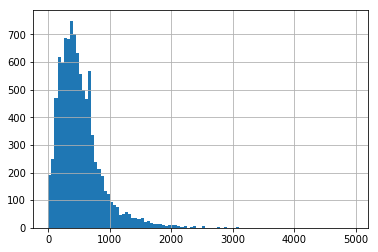

In [5]:
plot_length_distribution = omdb.omdb_plot.str.len()
plot_length_distribution.hist(bins = np.arange(1,5000,50))
print('Max: ',plot_length_distribution.max())
print('Min: ',plot_length_distribution.min())

In [6]:
omdb = omdb[omdb['omdb_plot'].str.len()>=20 ] # too small to predict
omdb = omdb[omdb['omdb_plot'].str.len()<=1500] # too large to predict

## Find all unique genres and their movie counts, sort in descending order

In [7]:
dict = find_all_genres(omdb)
sorted = sorted(dict.items(), key=operator.itemgetter(1), reverse = True)
sorted

[('Drama', 4489),
 ('Comedy', 2995),
 ('Action', 1905),
 ('Adventure', 1600),
 ('Crime', 1485),
 ('Romance', 1450),
 ('Thriller', 1162),
 ('Horror', 1139),
 ('Sci-Fi', 788),
 ('Fantasy', 759),
 ('Documentary', 708),
 ('Family', 657),
 ('Biography', 650),
 ('Mystery', 624),
 ('Animation', 534),
 ('History', 369),
 ('Music', 306),
 ('War', 293),
 ('Musical', 151),
 ('Sport', 135),
 ('Western', 126),
 ('Film-Noir', 81),
 ('Short', 65),
 ('News', 18),
 ('N/A', 9),
 ('Adult', 4),
 ('Talk-Show', 1)]

## Showing the distribution in bar chart

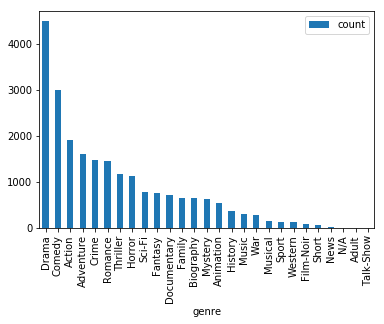

In [8]:
genre = pd.DataFrame(sorted, columns = ['genre','count'])
genre.plot.bar(x = 'genre')

## For genres who have count>=1000, create column for each of them

In [9]:
genres = list(genre for genre, count in sorted if count>=1000)
for each in genres:
    omdb[each] = genre_vec(each,omdb['omdb_genres'])
omdb.head()
# print(genres)

,omdb_genres,omdb_plot,Drama,Comedy,Action,Adventure,Crime,Romance,Thriller,Horror
0,"[Drama, History, War]","In this sprawling, star-laden film, we see the...",1,0,0,0,0,0,0,0
1,"[Action, Adventure, Thriller]",A cryptic message from the past sends James Bo...,0,0,1,1,0,0,1,0
2,"[Comedy, Horror]","The makers of this parody of ""Night of the Liv...",0,1,0,0,0,0,0,1
3,"[Adventure, Comedy, Drama]",Jack Crabb is 121 years old as the film begins...,1,1,0,1,0,0,0,0
4,"[Crime, Drama, Thriller]","When Perry and his girlfriend, Gail, cross pat...",1,0,0,0,1,0,1,0


## Use ML to predict each genre separately: Drama/not Drama, Comedy/not Comedy ...

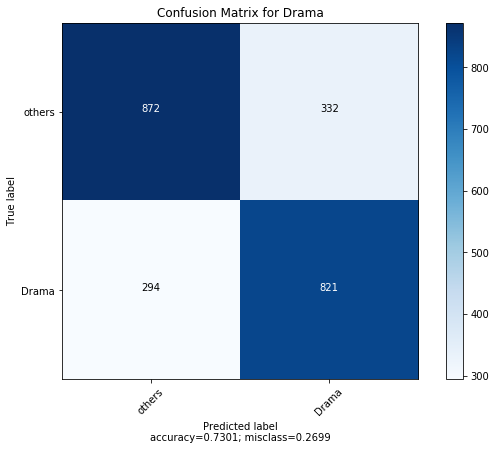

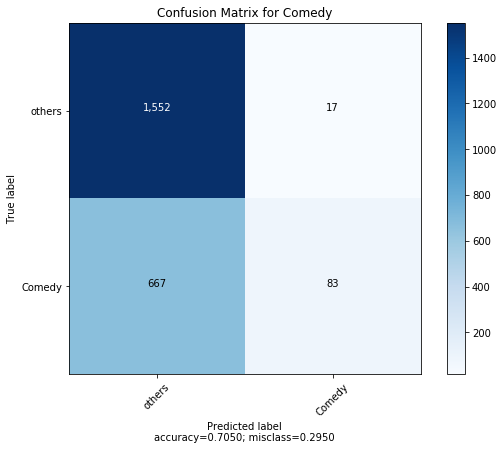

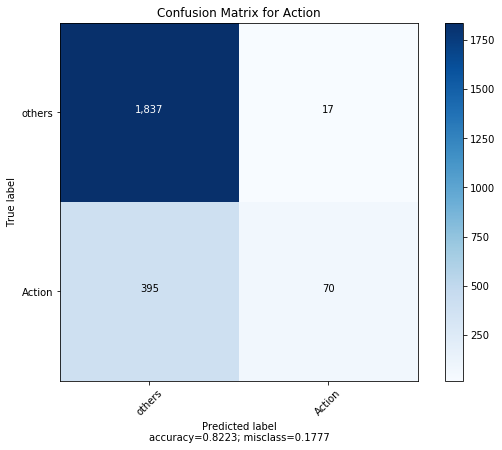

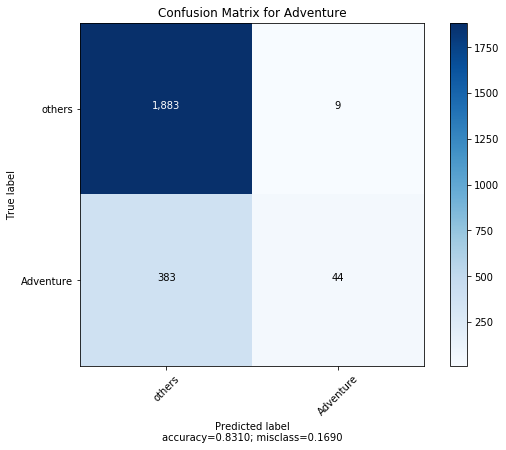

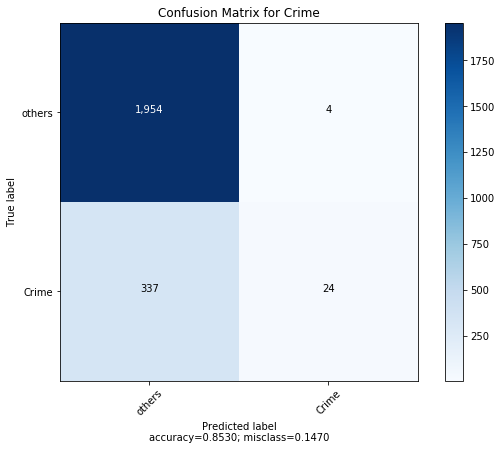

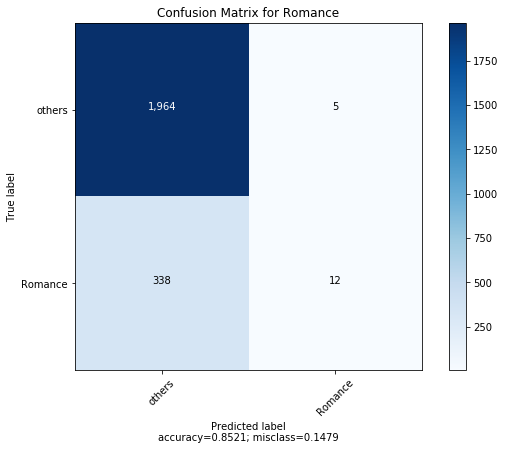

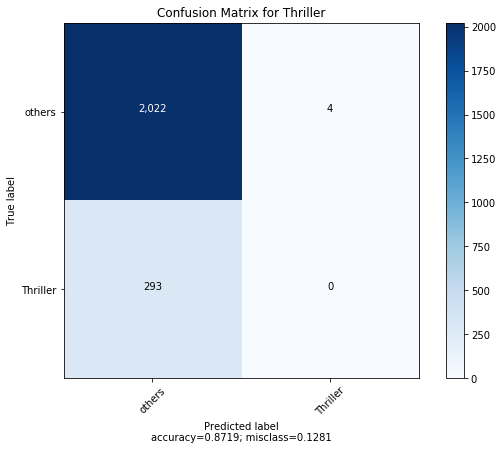

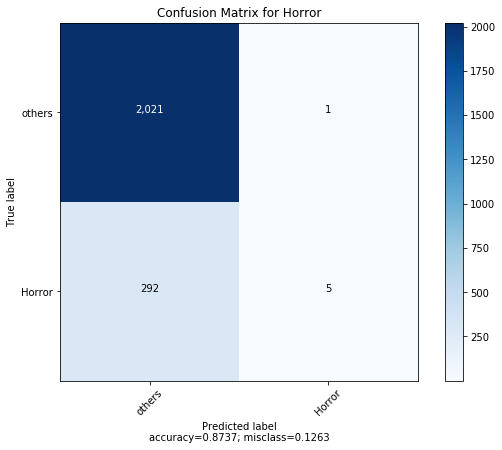

In [10]:
#I learned to use TfidfVectorizer at https://www.youtube.com/watch?v=GdsLRKjjKLw
TPR = {} # True Positive Rate

score = {}
for each in genres:
    
    vectorizer = TfidfVectorizer(max_df = 0.4, stop_words='english')
    X = omdb['omdb_plot']
    y = omdb[each]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_train = vectorizer.fit_transform(X_train)
    
    model = MultinomialNB(alpha=1, fit_prior=False)
    model.fit(X_train, y_train)
    
    X_test = vectorizer.transform(X_test)
    score.update({each:[model.score(X_test,y_test)]})
    
    predict = model.predict(X_test)
    cm = confusion_matrix(y_test, predict)
    TPR.update({each:[cm[1][1]/(cm[1][1]+cm[1][0])]})
    plot_confusion_matrix(cm, normalize = False, target_names = ['others', each], title = "Confusion Matrix for "+ str(each))
    
result = pd.DataFrame.from_dict(score)

## Accuracy Score for each model

In [11]:
result

,Drama,Comedy,Action,Adventure,Crime,Romance,Thriller,Horror
0,0.730056,0.705045,0.822337,0.830962,0.852954,0.852091,0.871928,0.873652


## True Positive Rate for each model

In [12]:
true_score = pd.DataFrame.from_dict(TPR)
true_score

,Drama,Comedy,Action,Adventure,Crime,Romance,Thriller,Horror
0,0.736323,0.110667,0.150538,0.103044,0.066482,0.034286,0.0,0.016835


## Only keep three most popular genres, append 'Other' to movies that do not belong to any of the two genres

In [13]:
genres = ['Drama','Comedy','Action','Other']
for lst in omdb['omdb_genres']:
    list = []
    for each in lst:
        if each not in genres:
            list.append(each)
    for each in list:
        lst.remove(each)
    if lst==[]:
        lst.append('Other')
omdb[['omdb_genres','omdb_plot']].head(n=10)

,omdb_genres,omdb_plot
0,[Drama],"In this sprawling, star-laden film, we see the..."
1,[Action],A cryptic message from the past sends James Bo...
2,[Comedy],"The makers of this parody of ""Night of the Liv..."
3,"[Comedy, Drama]",Jack Crabb is 121 years old as the film begins...
4,[Drama],"When Perry and his girlfriend, Gail, cross pat..."
5,[Drama],"Protagonist Alex DeLarge is an ""ultraviolent"" ..."
6,[Action],Captain Jack Sparrow (Depp) crosses paths with...
7,[Drama],It is the early 60s in France. The remaining s...
8,[Action],"On July 2nd, communications systems worldwide ..."
10,[Drama],This English-language adaptation of the Swedis...


## Try Multi-Label Classifier on 4 Labels: Drama, Comedy, Action and Other

In [14]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer


X = omdb['omdb_plot']
y = omdb['omdb_genres']
y = MultiLabelBinarizer().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y)


In [15]:
# I leaarned to use multi label classifier at https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df = 0.4, stop_words='english')),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    alpha=1,fit_prior=False))),
            ])

NB_pipeline.fit(X_train, y_train)
prediction = NB_pipeline.predict(X_test)
print(NB_pipeline.score(X_test, y_test))

0.2971108236308754


## Try Multi-Label Classifier on 3 Labels: Drama, Comedy and Other

In [16]:
genres = ['Drama','Comedy','Other']
for lst in omdb['omdb_genres']:
    list = []
    for each in lst:
        if each not in genres:
            list.append(each)
    for each in list:
        lst.remove(each)
    if lst==[]:
        lst.append('Other')


X = omdb['omdb_plot']
y = omdb['omdb_genres']
y = MultiLabelBinarizer().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y)
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(max_df = 0.4, stop_words='english')),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    alpha=1,fit_prior=False))),
            ])

NB_pipeline.fit(X_train, y_train)
prediction = NB_pipeline.predict(X_test)
print(NB_pipeline.score(X_test, y_test))

0.3656748598533851
